In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ing_theme_matplotlib import mpl_style

### In this first part we read the data (the dataframe which contains the geographical information about every accident) and drop some unnecesary columns

In [2]:
#READ DATASET IN CHUNKS
siniestros_georef = pd.read_csv('../data/CSV_georefer/siniestros_georef.csv',chunksize=10000)
siniestros = pd.read_csv('../data/CSVs/siniestros.csv',chunksize=10000)
#SPREAD CHUNKS IN ARRAY
%time
dfs_geo = [chunk for chunk in siniestros_georef]
dfs_sin = [chunk for chunk in siniestros]
#CONCATENATE CHUNKS IN A SINGLE DATAFRAME
%time
sin_g = pd.concat(dfs_geo)
sin = pd.concat(dfs_sin)

CPU times: total: 0 ns
Wall time: 0 ns
CPU times: total: 0 ns
Wall time: 0 ns


### In this case we have two dataframes with the same data: One with coordinates (georeferenciation) and the other without it. We will merge them on the accident's column in order to get the full info about the incidents and those rows which are not present in any of the datasets.

In [3]:
#CONCATENATE THE GEOFERENCIATED AND NON-GEOREFERENCIATED DATAFRAMES
siniestros_merged = pd.merge(sin_g,sin,on='CODIGO_ACCIDENTE',how='right')
#DELETE ROWS WITH 3 ASW VALUE IN THE COLUMN 'GRAVEDAD_y' BECAUSE THOSE ARE ACCIDENTS WITHOUT INJURIES OR DEATHS 
siniestros_merged = siniestros_merged.drop(siniestros_merged[siniestros_merged['GRAVEDAD_y'] == 3].index)
siniestros_merged = siniestros_merged.drop(['ANO_OCURRENCIA_ACC','MES_OCURRENCIA_ACC','DIA_OCURRENCIA_ACC','HORA_OCURRENCIA_ACC','FECHA_x','FORMULARIO','CIV','PK_CALZADA','GRAVEDAD_x','FECHA_HORA_ACC','CLASE_ACC','OBJECTID','X','Y'],axis=1)
siniestros_merged.memory_usage(deep=True)

Index                545864
CODIGO_ACCIDENTE     545864
LOCALIDAD           4351166
LATITUD              545864
LONGITUD             545864
FECHA_y             4571611
HORA                4435145
GRAVEDAD_y           545864
CLASE                545864
CHOQUE               545864
OBJETO_FIJO          545864
DIRECCION           5140261
CODIGO_LOCALIDAD     545864
DISENO_LUGAR         545864
dtype: int64

### In this part we modify some dtypes in order to optimize the memory usage of the dataframes

In [4]:
#CONVERT CODIGO_ACCIDENTE TO INT32
siniestros_merged['CODIGO_ACCIDENTE'] = siniestros_merged['CODIGO_ACCIDENTE'].astype(np.int32)
#IN THIS PART WE MODIFY THE VALUES IN THE COLUMN 'CHOQUE' WHERE IS EQUAL TO 4, BECAUSE IN THE RAW DATASET
#THE CONVENTION FOR THESE SPECIFIC VALUES IS 40 + THE VALUE IN THE COLUMN 'OBJETO_FIJO'
siniestros_merged['CHOQUE'] = np.where(siniestros_merged['CHOQUE']==4,40+siniestros_merged['OBJETO_FIJO'],siniestros_merged['CHOQUE'])
#CONVERT TO CATEGORY DTYPE
variables_to_category = ['GRAVEDAD_y','CLASE','DISENO_LUGAR','CHOQUE','OBJETO_FIJO']
def convert_to_category(df,variables):
    for i in variables:
        df[i] = df[i].astype('category')
#APPLY PREVIOUS METHOD TO THE DATAFRAME
convert_to_category(siniestros_merged,variables_to_category)
siniestros_merged['FECHA_HORA'] = siniestros_merged['FECHA_y'] +' '+ siniestros_merged['HORA']
siniestros_merged['FECHA_HORA'] = pd.to_datetime(siniestros_merged['FECHA_HORA'])
siniestros_merged = siniestros_merged.drop(['FECHA_y','HORA'],axis=1)

In [5]:
siniestros_merged.memory_usage(deep=True)

Index                545864
CODIGO_ACCIDENTE     272932
LOCALIDAD           4351166
LATITUD              545864
LONGITUD             545864
GRAVEDAD_y            68357
CLASE                 68589
CHOQUE                68925
OBJETO_FIJO           68893
DIRECCION           5140261
CODIGO_LOCALIDAD     545864
DISENO_LUGAR          68629
FECHA_HORA           545864
dtype: int64

### Here we'll do the same but with other useful datasets: actor_vial which contains full information about each one of the accidents and vehiculos which contains the information about the vehicles involved

In [6]:
#THIS DATASET IS THE DETAIL OF EACH ACCIDENT
actor_vial = pd.read_csv('../data/CSVs/actor_vial.csv',chunksize=10000,usecols=['CODIGO_ACCIDENTE','CODIGO_ACCIDENTADO','CONDICION','ESTADO','VEHICULO'])
#THIS DATASET CONTAINS THE DETAILS OF THE VEHICLES AND PEDESTRIANS INVOLVED IN THE ACCIDENTS
vehiculos = pd.read_csv('../data/CSVs/vehiculos.csv',chunksize=10000,usecols=['CODIGO_ACCIDENTE','VEHICULO','CLASE'])
#SPREAD CHUNKS IN ARRAY
dfs_av = [chunk for chunk in actor_vial]
dfs_veh = [chunk for chunk in vehiculos]
#CONCATENATE CHUNKS IN A SINGLE DATAFRAME
actor_vial = pd.concat(dfs_av)
vehiculos = pd.concat(dfs_veh)

#### In order to make our job easier, we will group the types of vehicles into five categories: Automovil, Bicicleta, Moto, Tr_Publico & Otros (car, bycicle, Powered Two-Wheeler, public transport & other types respectively). 
<br/><br/>
#### For other columns, we will do the same:
<br/><br/>
- ##### Condicion (victim condition): 

    - 1: Motociclista (PTW occupant)
    - 2: Pasajero/acompañante (Passenger)
    - 3: Peaton (Pedestrian)
    - 4: Ciclista (Cyclist)
    - 5: Conductor (Driver)
    
- ##### Estado (Victim's status):
    - 1: Dead
    - 2: Injured
    - 3: Unhurt
<br/><br/>

In [7]:
#FILTER TYPE OF VEHICLES BY THEIR CODES
vehiculos = vehiculos[vehiculos['CLASE'].isin([1,2,3,4,5,6,7,8,9,10,13,14,17,24,28])]
vehiculos = vehiculos.copy()
#DICTIONARY OF VEHICLES TYPES BASED ON THEIR CODE
mean_of_tr = {13:'Bicicleta',10:'Moto',
              17:'Moto',1:'Automovil',
              5:'Automovil',6:'Automovil',
             2:'Tr_publico',3:'Tr_publico',
             7:'Tr_publico',4:'Otro',
             8:'Otro',9:'Otro',14:'Otro',24:'Otro',28:'Otro'}

vehiculos['CLASE'] = vehiculos['CLASE'].map(mean_of_tr)

condicion_dict = {'MOTOCICLISTA':1,'PASAJERO/ACOMPAÑANTE':2,'PEATON':3,'CICLISTA':4,'CONDUCTOR':5}

estado_dict = {'MUERTO':1,'HERIDO':2,'ILESO':3}

actor_vial['CONDICION'] = actor_vial['CONDICION'].map(condicion_dict)
actor_vial['ESTADO'] = actor_vial['ESTADO'].map(estado_dict)

### In the following cell we merge actor_vial & vehiculos on the vehicles code with the aim of expanding the information about each accident. The merge is left because some vehicles don't have code, because they are either pedestrians or vehicles that got away

In [8]:
#CREATE A DATAFRAME WHICH CONTAINS DETAILS ABOUT EACH INCIDENT AND VEHICLES INVOLVED (TYPE OF VEHICLE AND CODE)
actor_vial_merge = pd.merge(actor_vial,vehiculos,on='VEHICULO',how='left')
actor_vial_merge = actor_vial_merge.drop('CODIGO_ACCIDENTE_y',axis=1)

### In the following cell, we create a dictionary with the accident's code as key and kind of accident as value

In [9]:
cod_serious_accidents = siniestros_merged['CODIGO_ACCIDENTE'].to_list()
#IN ORDER TO GET THE KIND OF ACCIDENT, WE'LL MAP IT BASED ON THE ACCIDENT'S CODES
siniestros_merged_dict = siniestros_merged[['CODIGO_ACCIDENTE','CLASE']]
siniestros_merged_dict.index = cod_serious_accidents
siniestros_merged_dict = siniestros_merged_dict.drop('CODIGO_ACCIDENTE',axis=1)
siniestros_merged_dict = siniestros_merged_dict.to_dict()['CLASE']

### In the following cells we first filter those accident with serious casualties (those with injured or dead people) from the actor_vial_merge dataframe which contains detailed information about each accident and vehicles involved. Then we fill NA values with zero and finally create a very useful column, called AFECTADO (affected) which contains 1 if the person involved was injured or died in the accident

In [10]:
#FILL NA VALUES WITH ZEROS (THESE ARE THE PEDESTRIANS)
actor_vial_merge['VEHICULO'] = actor_vial_merge['VEHICULO'].fillna(0)
#GET ACCIDENTS FROM THE ACCIDENT DETAIL DATAFRAME THAT ARE IN THE PREVIOUS LIST OF CODES
actor_vial_merge = actor_vial_merge[actor_vial_merge['CODIGO_ACCIDENTE_x'].isin(cod_serious_accidents)]
#MAP KIN OF ACCIDENT DICTIONARY ON THE DATAFRAME
actor_vial_merge['TIPO_SINIESTRO'] = actor_vial_merge['CODIGO_ACCIDENTE_x'].map(siniestros_merged_dict)
len(actor_vial_merge['CODIGO_ACCIDENTE_x'].unique())
#DROP HIT-AND-RUN ACCIDENTS
actor_vial_merge = actor_vial_merge.drop(actor_vial_merge[(actor_vial_merge['CLASE'].isnull()) & (actor_vial_merge['VEHICULO'] != 0)].index)

In [11]:
actor_vial_merge = actor_vial_merge.copy()
actor_vial_merge['CLASE'] = actor_vial_merge['CLASE'].fillna(0)
#CREATE NEW COLUMN AFECTADO, WHICH VALUE IS 1 IF THE PERSON (A ROW IN THIS DATAFRAME) WAS EITHER INJURED OR DEATH
actor_vial_merge['AFECTADO'] = actor_vial_merge['ESTADO'].apply(lambda item: 1 if item in [1,2] else 0)

### In this cells we group the data by accident's code and vehicle involved and aggregate function on the column AFECTADO which contains 1 if the person involved (each one row) was affected (injured or dead) or 0 if they didn't. 

In [12]:
#GROUP BY ACCIDENT CODE AND VEHICLE IN ORDER TO GET THE AMOUNT OF VICTIMS PER VEHICLE FOR EVERY ACCIDENT
cant_afect_x_accidente= actor_vial_merge.groupby(['CODIGO_ACCIDENTE_x','VEHICULO'])['AFECTADO'].sum()
cant_afect_x_accidente = cant_afect_x_accidente.reset_index()

cant_afect_x_accidente['CLASE'] = cant_afect_x_accidente['VEHICULO']

In [13]:
#CREATE DICTIONARY IN ORDER TO MAP AND REPLACE THE VEHICLE CODE BY THE KIND OF VEHICLE
cod_vehiculos = vehiculos[['VEHICULO','CLASE']]
cod_vehiculos.index = cod_vehiculos['VEHICULO']
cod_vehiculos = cod_vehiculos.drop('VEHICULO',axis=1).to_dict()['CLASE']
#CREATE KEY '0' IN THE DICTIONARY WHICH MEANS 'Peaton' (PEDESTRIAN)
cod_vehiculos[0] = 'Peaton'
cant_afect_x_accidente['CLASE'] = cant_afect_x_accidente['CLASE'].map(cod_vehiculos)
cant_afect_x_accidente = cant_afect_x_accidente[cant_afect_x_accidente['CLASE'].notna()]

### For this project we need to know the vehicles involved or combination, that is, who hit who. for example, *car - pedestrian* or public *transport - PTW*. We will do so in the following cell

In [14]:
#FUNCTION TO JOIN EVERY VEHICLE INVOLVED FOR EVERY ACCIDENT
def join_veh_types(item):
    resultant_arr = [i for i in item]
    return resultant_arr
#APPLY FUNCTION TO THE COLUMN CLASE (PANDAS SERIES OF THE VEHICLES INVOLVED PER ACCIDENT)
accident_combination = cant_afect_x_accidente.groupby('CODIGO_ACCIDENTE_x')['CLASE'].apply(join_veh_types)
accident_combination = accident_combination.reset_index()

### In this part we will summarize the vehicles involved combination based on the following conditions: If there are more than 3 different types of vehicles, delete it. If there one or at maximum two types of vehicles involved (no matter the amount) leave it. If there are more than 2 different types of vehicles and at least a cyclist or pedestrian involved, leave it.

In [15]:
def join_items(l):
    l = sorted(l)
    if len(l) > 2:
        l = set(l)
    if len(l) == 1 and isinstance(l,set):
        l = list(l)
        l.append(l[0])
        l = sorted(l)
    if len(l) > 2 and not any(x in ['Peaton','Bicicleta'] for x in l):
            return 0
    return '-'.join(str(item) for item in l)
accident_combination.loc[:,'CLASE'] = accident_combination.loc[:,'CLASE'].apply(join_items)

### Let's grab a subset from the accident's dataframe (siniestros_merged, the first one we worked with) in order to merge additional useful information and create a derived dataframe that we are going to use later

In [16]:
#RENAME COLUMN 'CODIGO_ACCIDENTE_x' TO 'CODIGO_ACCIDENTE' TO BE ABLE TO MERGE WITH THE DATAFRAME 'siniestros_merged_subset'
accident_combination = accident_combination.rename({'CODIGO_ACCIDENTE_x':'CODIGO_ACCIDENTE'},axis=1)

siniestros_merged_subset = siniestros_merged[['CODIGO_ACCIDENTE','LOCALIDAD','CODIGO_LOCALIDAD','FECHA_HORA']]

accident_combination = accident_combination.copy()
accident_combination = pd.merge(accident_combination,siniestros_merged_subset,on='CODIGO_ACCIDENTE',how='inner')

### Now let's merge every accident with the details dataframe which contains the detailed information about each accident in the dataframe 'accident_combination'

In [17]:
cant_afect_x_accidente = cant_afect_x_accidente.rename({'CODIGO_ACCIDENTE_x':'CODIGO_ACCIDENTE'},axis=1)
cant_afect_x_accidente = pd.merge(cant_afect_x_accidente,accident_combination,how='inner',on='CODIGO_ACCIDENTE')
cant_afect_x_accidente = cant_afect_x_accidente.rename({'CLASE_y':'COMBINACION'},axis=1)

In [18]:
#READ FILE WHERE THE SUBURB NAMES IS STORED BY CODE
cod_loc = pd.read_excel('../data/EXCELs/codigos_loc.xlsx',index_col=None,header=None)
cod_loc.index = np.arange(1,21)
cod_loc = cod_loc.drop([0,1],axis=1).rename({2:'LOCALIDAD'},axis=1)

cod_loc = cod_loc['LOCALIDAD'].to_dict()

cant_afect_x_accidente = cant_afect_x_accidente.drop(cant_afect_x_accidente[cant_afect_x_accidente['COMBINACION'].isin(['0',0])].index)

cant_afect_x_accidente['CODIGO_LOCALIDAD'] = cant_afect_x_accidente['CODIGO_LOCALIDAD'].map(cod_loc)

### Group dataframe by vehicles crash combination and vehicle kind, then aggregate function on the column AFECTADO in order to get the amount of affected people per vehicle involved per accident. This dataset is going to be useful when creating the pivot table to plot the casualties matrix.

In [19]:
count_afectados_x_tipo = cant_afect_x_accidente.groupby(['COMBINACION','CLASE_x'])['AFECTADO'].sum()
count_afectados_x_tipo = count_afectados_x_tipo.reset_index()

In [20]:
#THIS FUNCTION TAKES AS PARAMETERS THE COLUMN (SERIES OF VEHICLES CRASH COMBINATIONS) AND THE MAXIMUM
#NUMBER OF DIFFERENT VEHICLE TYPES THAT CAN BE INVOLVED. THOSE THAT EXCEED THIS NUMBER, ARE REPLACE BY A 0
def check_multiple_vehicles(item,limit):
    item = item.split('-')
    if len(item) > limit:
        return 0
    return '-'.join(str(i) for i in item)
count_afectados_x_tipo['COMBINACION'] = count_afectados_x_tipo['COMBINACION'].apply(check_multiple_vehicles,limit = 2)

In [21]:
#LET'S CHECK HOW MANY PILEUPS ARE IN THE DATASET
total_accidents = count_afectados_x_tipo['AFECTADO'].sum()
pileups = count_afectados_x_tipo[count_afectados_x_tipo['COMBINACION'] == 0]['AFECTADO'].sum()
total_accidents,pileups

(96324, 2520)

### The pileups in the dataset don't represent more than 4% of the total crashes, so we can delete them and leave only those with only two parties

In [22]:
count_afectados_x_tipo = count_afectados_x_tipo[count_afectados_x_tipo['COMBINACION'] != 0]

In [23]:
#THIS FUNCTION DELETES THE KIND OF VEHICLE INVOLVED FROM THE COMBINATION, IN ORDER TO GET RID OF THE REDUNDANCE OF THE INFORMATION
#AND GET THE CHANCE OF RESTRUCTURING THE DATAFRAME AS A PIVOT TABLE
def delete_vehicle_type(item,veh):
    item = item.split('-')
    item.remove(veh)
    return ''.join(item)
count_afectados_x_tipo['COMBINACION'] = np.vectorize(delete_vehicle_type)(count_afectados_x_tipo['COMBINACION'],count_afectados_x_tipo['CLASE_x'])

### In this part we will create a pivot table, which is casualties matrix that gives information about the amount of victims per combination. For example, for the combination car - pedestrian there are 8097 casualties.

In [24]:
pivot_accidents = pd.pivot_table(count_afectados_x_tipo, values='AFECTADO', index=['CLASE_x'],
                    columns=['COMBINACION'],aggfunc=np.sum)
pivot_accidents = pivot_accidents.rename({'':'Mismo'},axis=1)

In [25]:
new_cols_order = ['Mismo','Peaton','Bicicleta','Moto','Automovil','Tr_publico','Otro']
pivot_accidents = pivot_accidents.reindex(columns=new_cols_order,index=new_cols_order)
pivot_accidents = pivot_accidents.drop('Mismo',axis=0)
pivot_accidents = pivot_accidents.fillna(0)
pivot_accidents.loc['Peaton','Mismo'] = 0

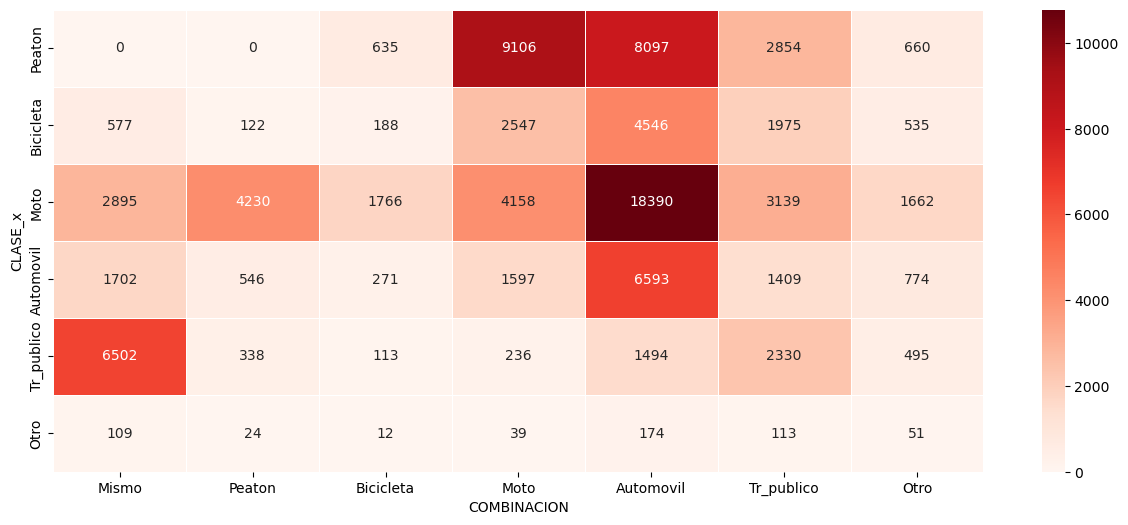

In [26]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(pivot_accidents, annot=True, fmt='g', linewidths=.55, ax=ax, cmap='Reds',robust=True);

### Now let's do the same but for every borough (localidad) which is a great part of the city with multiple neighborhoods in it. To simplify what was done in the previous 8 cells, we will create a function in which we are going to wrap all that code

In [27]:
#THIS FUNCTION PERFORMS BASICALLY THE SAME TASKS AS THE CELLS ABOVE. WE CREATED IT BECAUSE WE NEED TO APPLY THIS
#FOR EACH DISTRICT (LOCALIDAD) GIVEN THAT FOR EVERY ONE OF THEM THERE IS A DATAFRAME
def generate_casualties_matrix(df,combination_col,veh_kind_col,num_casualties_per_accident,cols_order):
    count_afectados_x_tipo = df.groupby([combination_col,veh_kind_col])[num_casualties_per_accident].sum()
    count_afectados_x_tipo = count_afectados_x_tipo.reset_index()
    count_afectados_x_tipo[combination_col] = count_afectados_x_tipo[combination_col].apply(check_multiple_vehicles,limit = 2)
    
    total_accidents = count_afectados_x_tipo[num_casualties_per_accident].sum()
    
    pileups = count_afectados_x_tipo[count_afectados_x_tipo[combination_col] == 0][num_casualties_per_accident].sum()
    pileups_rate = pileups/total_accidents
    if(pileups_rate < 0.05):
        count_afectados_x_tipo = count_afectados_x_tipo[count_afectados_x_tipo[combination_col] != 0]
    
    count_afectados_x_tipo = count_afectados_x_tipo.groupby([veh_kind_col,combination_col])[num_casualties_per_accident].sum()
    count_afectados_x_tipo = count_afectados_x_tipo.reset_index()
    count_afectados_x_tipo[combination_col] = np.vectorize(delete_vehicle_type)(count_afectados_x_tipo[combination_col],count_afectados_x_tipo[veh_kind_col])
    
    pivot_df = pd.pivot_table(count_afectados_x_tipo, values=num_casualties_per_accident, index=[veh_kind_col],
                    columns=[combination_col],aggfunc=np.sum)
    pivot_df = pivot_df.rename({'':'Mismo'},axis=1)
    pivot_df = pivot_df.reindex(columns=cols_order,index=cols_order)
    pivot_df = pivot_df.drop('Mismo',axis=0)
    pivot_df = pivot_df.fillna(0)
    pivot_df.loc['Peaton','Mismo'] = 0
    
    return pivot_df

### Let's plot the casualties matrix per borough. For this, we will first fetch the boroughs names and then create a dataframe for every of them with their respective rows 

In [28]:
localidades_list = [i for i in cant_afect_x_accidente['LOCALIDAD'].unique() if str(i) != 'nan']
pivot_df_list = []
for i in localidades_list:
    df = cant_afect_x_accidente[cant_afect_x_accidente['LOCALIDAD'] == i]
    df = generate_casualties_matrix(df,'COMBINACION','CLASE_x','AFECTADO',new_cols_order)
    pivot_df_list.append(df)

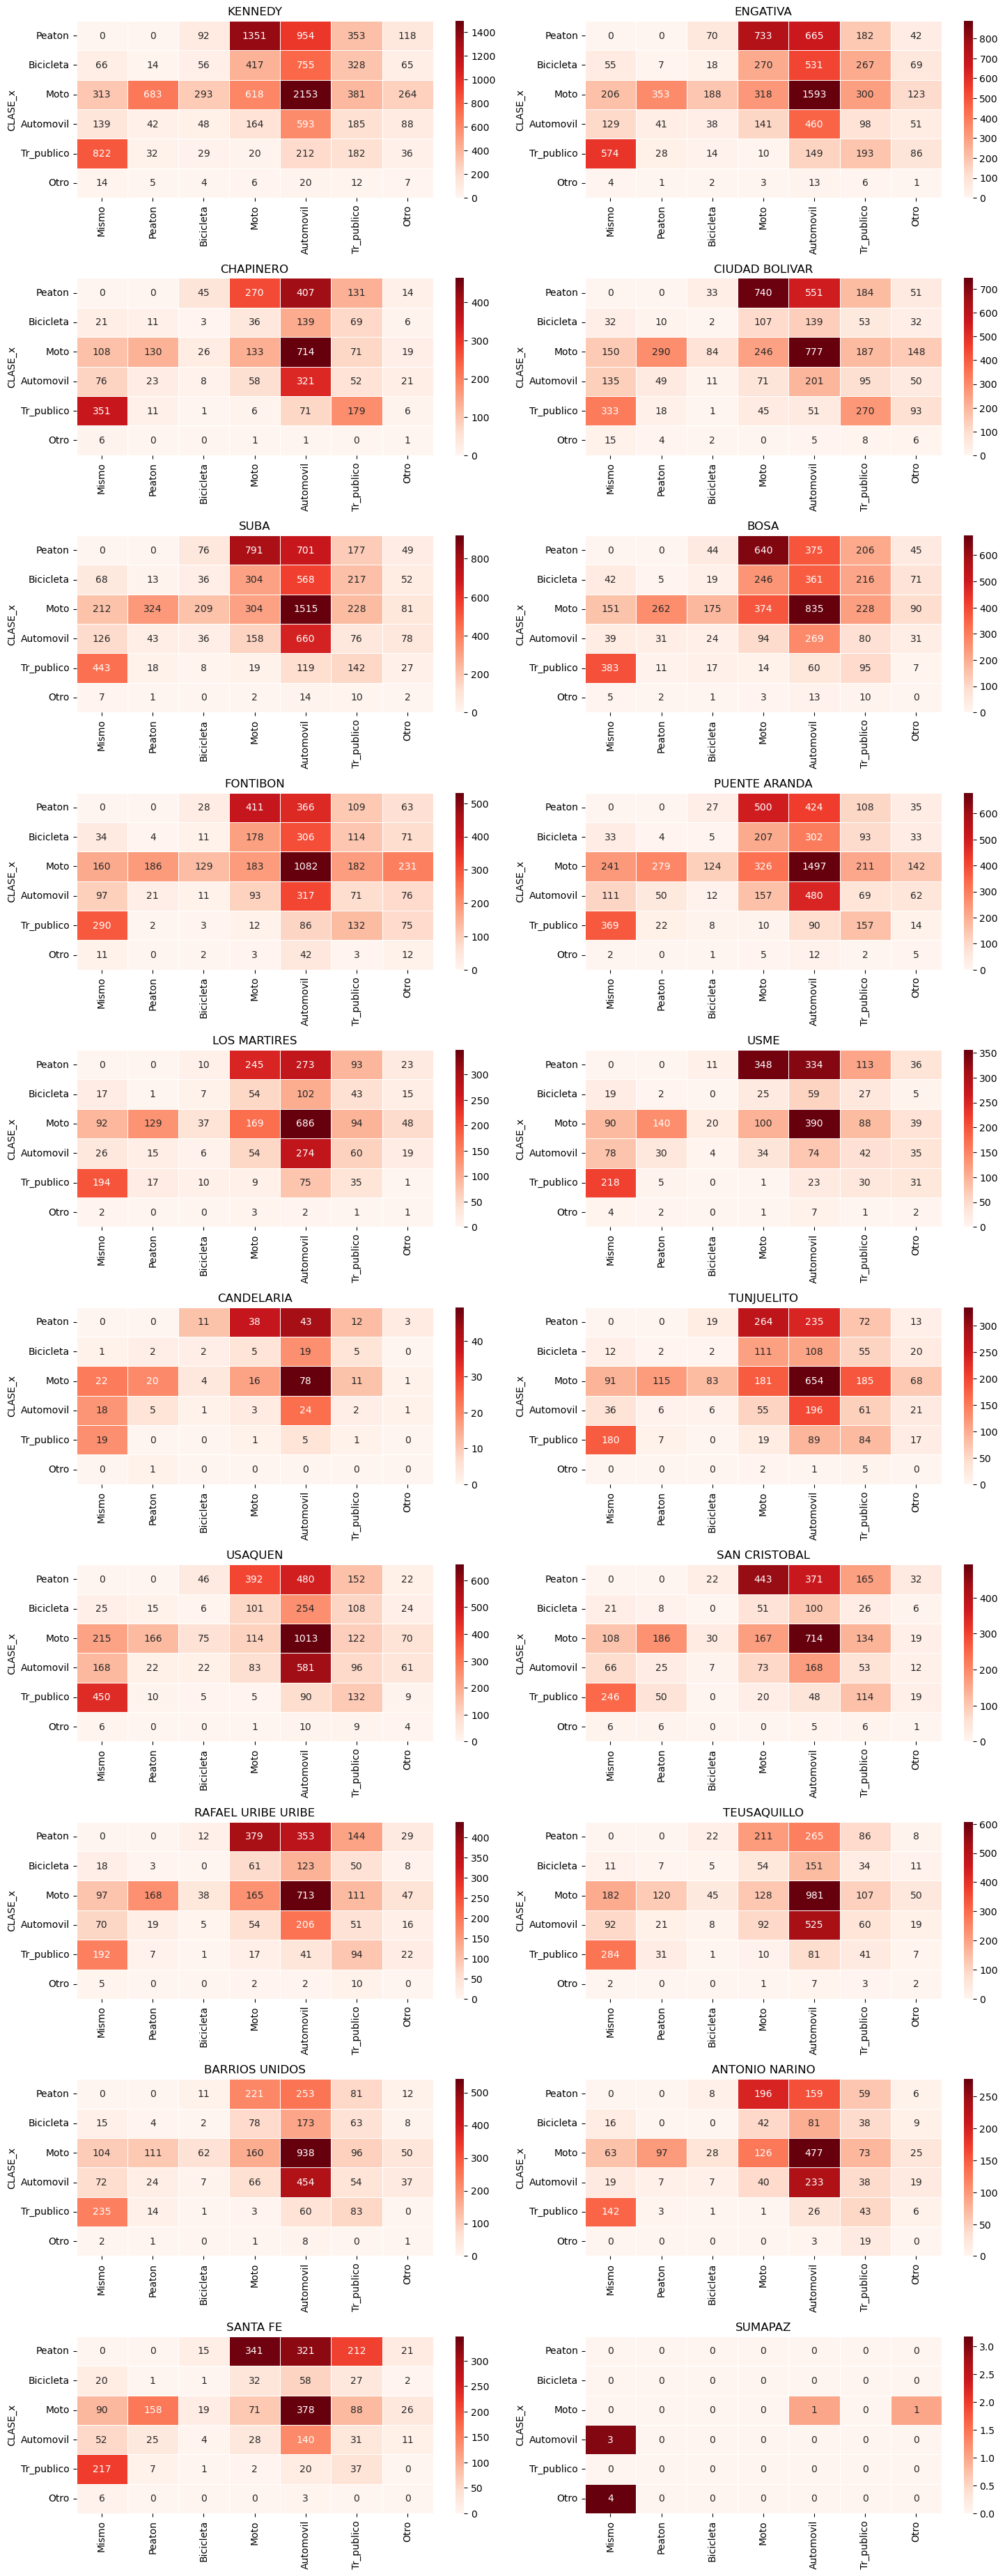

In [29]:
plt.figure(figsize=(15,40))
plt.subplots_adjust(hspace=0.5)
arr = zip(localidades_list,pivot_df_list)
for i,dfs in enumerate(arr):
    ax = plt.subplot(11,2,i+1)
    sns.heatmap(dfs[1], annot=True, fmt='g', linewidths=.55, ax=ax, cmap='Reds',robust=True);
    ax.set_title('{0}'.format(dfs[0]))
    ax.get_legend()
    ax.set_xlabel("")
plt.tight_layout()

### Finally we will modifiy the column 'COMBINACION' in the dataframe 'cant_afect_x_accidente', in order to have a dataframe with the full information, then exported it to visualize the data in a data visualization tool

In [29]:
cant_afect_x_accidente = cant_afect_x_accidente.copy()
cant_afect_x_accidente['COMBINACION'] = cant_afect_x_accidente['COMBINACION'].apply(check_multiple_vehicles,limit=2)
cant_afect_x_accidente = cant_afect_x_accidente[cant_afect_x_accidente['COMBINACION'] != 0]
cant_afect_x_accidente['COMBINACION'] = np.vectorize(delete_vehicle_type)(cant_afect_x_accidente['COMBINACION'],cant_afect_x_accidente['CLASE_x'])

cant_afect_x_accidente.loc[cant_afect_x_accidente['COMBINACION'] == '','COMBINACION'] = 'Mismo'

In [30]:
cant_afect_x_accidente[cant_afect_x_accidente['CODIGO_ACCIDENTE']==10489479]

,CODIGO_ACCIDENTE,VEHICULO,AFECTADO,CLASE_x,COMBINACION,LOCALIDAD,CODIGO_LOCALIDAD,FECHA_HORA
102363,10489479,0,7,Peaton,Automovil,SUBA,SUBA,2019-02-07 16:34:00
102364,10489479,10489479-1,1,Automovil,Peaton,SUBA,SUBA,2019-02-07 16:34:00


In [32]:
cant_afect_x_accidente[(cant_afect_x_accidente['CLASE_x'] == 'Peaton') & (cant_afect_x_accidente['COMBINACION'] == 'Mismo')]

,CODIGO_ACCIDENTE,VEHICULO,AFECTADO,CLASE_x,COMBINACION,LOCALIDAD,CODIGO_LOCALIDAD,FECHA_HORA
71,4401487,0,1,Peaton,Mismo,SUBA,SUBA,2015-04-01 22:00:00
378,4401926,0,1,Peaton,Mismo,USAQUEN,USAQUEN,2015-12-01 21:40:00
392,4401984,0,1,Peaton,Mismo,SAN CRISTOBAL,SAN CRISTOBAL,2015-09-01 15:20:00
478,4402080,0,1,Peaton,Mismo,TEUSAQUILLO,TEUSAQUILLO,2015-01-14 19:00:00
521,4402117,0,1,Peaton,Mismo,CIUDAD BOLIVAR,CIUDAD BOLIVAR,2015-01-14 23:40:00
...,...,...,...,...,...,...,...,...
130922,10533582,0,1,Peaton,Mismo,SUBA,BARRIOS UNIDOS,2020-02-08 19:19:00
130927,10533594,0,1,Peaton,Mismo,BOSA,BOSA,2020-09-08 23:20:00
130928,10533595,0,1,Peaton,Mismo,ANTONIO NARINO,ANTONIO NARIÑO,2020-10-08 10:24:00
130945,10533609,0,1,Peaton,Mismo,USAQUEN,USAQUEN,2020-08-28 21:27:00


In [31]:
cant_afect_x_accidente.to_csv('../data/CSV_georefer/victimas_full_info.csv', encoding='utf-8', index=False)